In [1]:
# Essentials
import os, sys, glob
import pandas as pd
import numpy as np
import nibabel as nib
import scipy.io as sio
from tqdm import tqdm

# Stats
import scipy as sp
from scipy import stats
import statsmodels.api as sm
import pingouin as pg

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
from sklearn.cluster import KMeans
from numpy.matlib import repmat
from scipy.linalg import svd, schur
from timeit import default_timer as timer

/Users/lindenmp/opt/anaconda3/envs/pfactor_gradients/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.9, the latest is 0.3.10.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [3]:
sys.path.append('/Users/lindenmp/Google-Drive-Penn/work/research_projects/pathlength_tuning/1_code/')
from func import set_proj_env, my_get_cmap
from func import get_B_matrix, subsample_state, optimal_energy, minimum_energy, minimum_energy_nonh, get_time_vec, minimum_energy_taylor

In [4]:
parc_str = 'schaefer' # 'schaefer' 'lausanne' 'glasser'
parc_scale = 400 # 200/400 | 125/250 | 360
edge_weight = 'streamlineCount' # 'streamlineCount' 'volNormStreamline'
set_proj_env()

('/Users/lindenmp/Google-Drive-Penn/work/research_projects/pfactor_gradients',
 '/Users/lindenmp/Google-Drive-Penn/work/research_projects/pfactor_gradients/0_data',
 '/Volumes/work_ssd/research_data/PNC/',
 '/Users/lindenmp/Google-Drive-Penn/work/research_projects/pfactor_gradients/2_pipeline',
 '/Users/lindenmp/Google-Drive-Penn/work/research_projects/pfactor_gradients/3_output')

In [5]:
# output file prefix
outfile_prefix = parc_str+'_'+str(parc_scale)+'_'+edge_weight+'_'
outfile_prefix

'schaefer_400_streamlineCount_'

### Setup directory variables

In [6]:
print(os.environ['PIPELINEDIR'])
if not os.path.exists(os.environ['PIPELINEDIR']): os.makedirs(os.environ['PIPELINEDIR'])

/Users/lindenmp/Google-Drive-Penn/work/research_projects/pfactor_gradients/2_pipeline


In [7]:
figdir = os.path.join(os.environ['OUTPUTDIR'], 'figs')
print(figdir)
if not os.path.exists(figdir): os.makedirs(figdir)

/Users/lindenmp/Google-Drive-Penn/work/research_projects/pfactor_gradients/3_output/figs


## Setup plots

In [8]:
if not os.path.exists(figdir): os.makedirs(figdir)
os.chdir(figdir)
sns.set(style='white', context = 'talk', font_scale = 1)
cmap = my_get_cmap('pair')

## Load data

20
[58 17 14 16 17 10 17 37 19 32 19 29 11 30  7  7 10 23  7 20]


Text(0, 0.5, 'Gradient 1')

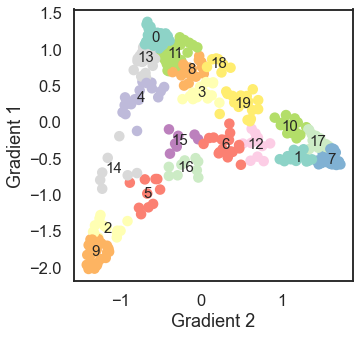

In [9]:
gradients = np.loadtxt(os.path.join(os.environ['PIPELINEDIR'], '1_compute_gradient', 'out', outfile_prefix+'pnc_grads_template.txt'))
num_parcels = gradients.shape[0]
n_clusters=int(num_parcels*.05)
print(n_clusters)
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(gradients)

unique, counts = np.unique(kmeans.labels_, return_counts = True)
print(counts)

f, ax = plt.subplots(figsize=(5, 5))
ax.scatter(gradients[:,1], gradients[:,0], c = kmeans.labels_, cmap= 'Set3')
# ax.scatter(kmeans.cluster_centers_[:,1], kmeans.cluster_centers_[:,0], marker = 'x', c = 'k', s = 100)
for i, txt in enumerate(np.arange(n_clusters)):
    ax.annotate(txt, (kmeans.cluster_centers_[i,1], kmeans.cluster_centers_[i,0]), ha="center", va="center", size=15)
ax.set_xlabel('Gradient 2')
ax.set_ylabel('Gradient 1')

In [10]:
from bct.algorithms.distance import retrieve_shortest_path, distance_wei_floyd
A = np.load(os.path.join(os.environ['PIPELINEDIR'], '0_get_sample', 'out', outfile_prefix+'disc_mean_A_s6.npy'))

/Users/lindenmp/opt/anaconda3/envs/pfactor_gradients/lib/python3.7/site-packages/bct/algorithms/distance.py:392: RuntimeWarning: divide by zero encountered in true_divide
  SPL = 1. / adjacency


15.0
6.1513625


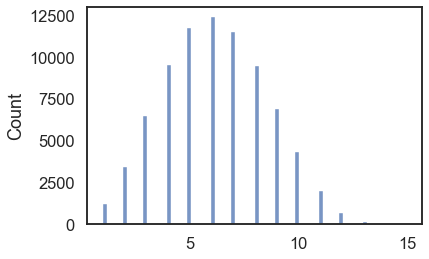

In [11]:
D, hops, Pmat = distance_wei_floyd(A, transform = 'inv')
sns.histplot(hops[np.triu_indices(num_parcels, k=1)])
print(np.max(hops))
print(np.mean(hops))

In [12]:
T = 1
rho = 1.0
S = np.eye(num_parcels)
B_ver = 'x0xfwb'

In [13]:
unique, counts = np.unique(kmeans.labels_, return_counts = True)
subsample_size = np.min(counts)
# subsample_size = 30
print(subsample_size)

7


In [14]:
x0 = kmeans.labels_ == 0
print(np.sum(x0))
xf = kmeans.labels_ == 9
print(np.sum(xf))

np.random.seed(0)
x0_tmp = subsample_state(x0, subsample_size)
xf_tmp = subsample_state(xf, subsample_size)

B = get_B_matrix(x0_tmp, xf_tmp, version = B_ver)

58
32


In [15]:
start = timer()
e_min_nonh = minimum_energy_nonh(A,T,B,x0_tmp,xf_tmp)
end = timer()
print(end-start)

20.060136610999997


In [16]:
start = timer()
e_min_taylor = minimum_energy_taylor(A,T,B,x0_tmp,xf_tmp)
end = timer()
print(end-start)

2.4937887370000027


0.42574767199999997


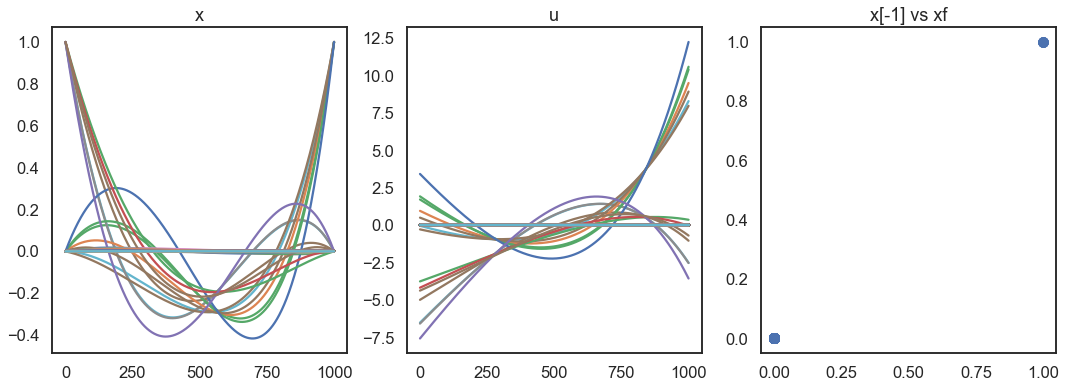

In [17]:
start = timer()
x, u, n_err = minimum_energy(A,T,B,x0_tmp,xf_tmp)
end = timer()
print(end-start)

u = np.multiply(np.matlib.repmat(B[np.eye(num_parcels) == 1],u.shape[0],1),u) # scale energy
e_min = np.sum(np.square(u))

f, ax = plt.subplots(1,3, figsize=(18,6))
ax[0].plot(x)
ax[0].set_title('x')
ax[1].plot(u)
ax[1].set_title('u')
ax[2].scatter(x[-1,:],xf_tmp)
ax[2].set_title('x[-1] vs xf')
plt.show()

0.525546766999998


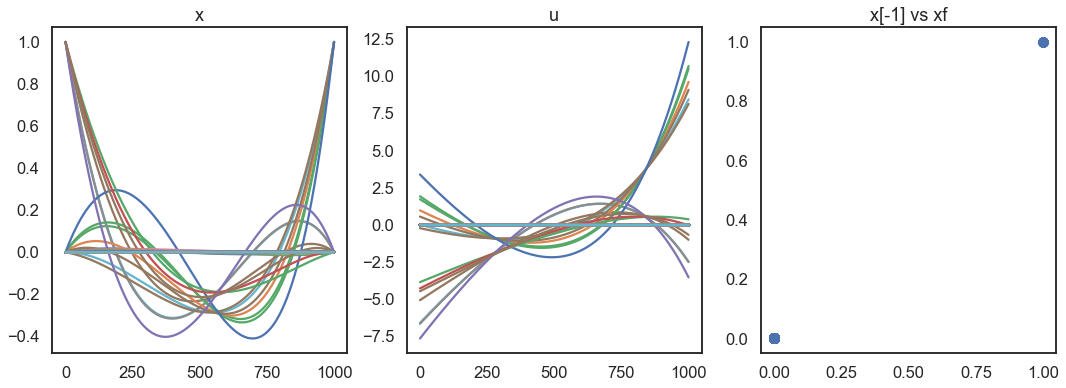

In [18]:
start = timer()
x, u, n_err = optimal_energy(A,T,B,x0_tmp,xf_tmp,rho,S)
end = timer()
print(end-start)

u = np.multiply(np.matlib.repmat(B[np.eye(num_parcels) == 1],u.shape[0],1),u) # scale energy
e_opt = np.sum(np.square(u))

f, ax = plt.subplots(1,3, figsize=(18,6))
ax[0].plot(x)
ax[0].set_title('x')
ax[1].plot(u)
ax[1].set_title('u')
ax[2].scatter(x[-1,:],xf_tmp)
ax[2].set_title('x[-1] vs xf')
plt.show()

In [19]:
print(e_min_nonh,e_min_taylor,e_min,e_opt)

105.6826876578379 105.6804363840121 95285.43305423764 95480.64265580439
